# STEP 0

## 0.1. Imports


In [172]:
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics        import precision_score, f1_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, TargetEncoder
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_score
from sklearn.ensemble       import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost                   import CatBoostRegressor, Pool

## 0.2. Funções de apoio

In [162]:
# ===================================================================
# Configura o notebook
def jupyter_settings():
    import warnings
    # warnings.filterwarnings('ignore')
    # %matplotlib inline

    # Tamanho e estilo dos gráficos
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [22, 9]
    plt.rcParams['font.size'] = 21

    # Configuração de exibição das linhas e colunas do pandas
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)

    # configuração do pandas para quantidade de casas decimais
    pd.set_option('display.float_format', lambda x: '%.2f' % x)

    sns.set()

jupyter_settings()

# Imprime n gráficos do tipo boxplot lado a lado
def exibe_boxplot(data, col):
    '''    
    '''
    
    indice = 1
    for coluna in data.columns:
        plt.subplot(1, col, indice)
        sns.boxplot(data[coluna]).set(title=coluna)
        indice += 1


def plota_ausentes(data, title, x_title):
    """
    Plota uma tabela com a contagem de valores ausentes por coluna e um gráfico de
    barras com o percentual de ausentes por colunas caso existam dados ausentes,
    caso não, imprime o resultado de isna().sum()
    Params
    data: dataframe com os dados a serem plotados
    title: título do gráfico
    title: título do eixo x
    """

    # Pega as colunas com dados ausentes
    colunas_com_nan = [col for col in data if data[col].isna().sum() > 0]

    # Plot do gráfico de barras com o percentual
    if len(colunas_com_nan) > 0:    # Se tiver colunas com dados faltantes
        ax = (  # Grafico                              
            data[colunas_com_nan]   # Dataframe a ser plotado no gráfico
            .isna() # Pegar valores faltantes
            .mean() # Pegar a média dos valores faltantes
            .sort_values(ascending=True)    # Ordenar os dados 
            .mul(100)   # multiplicar a média por 100 (percentual)
            .round(1)   # Arredondar as casas decimais para 1
            .plot(kind="barh")  # Tipo do gráfico (barras horizontais)
        )
        _ = ax.set_xlabel(x_title)  # Título do eixo x
        _ = ax.set_title(title) # Título do gráfico
        _ = ax.bar_label(ax.containers[0])  # Mostrar valores sobre as barras

        # Tabela da contagems dos dados faltantes
        print("Contagem de faltantes")
        print(data[colunas_com_nan].isna().sum().sort_values(ascending=True))
    else:   # Caso não exista dados faltantes imprime uma lista das colunas
        print('Contagem de faltantes')
        print(data.isna().sum())

# Terminar no próximo notebook
def calcula_metricas(modelo, y_test, y_pred):
    # Avaliando o modelo
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    # =======================================
    # Retornando a tabela de métricas
    # =======================================
    linhas = [[modelo, precision, f1, accuracy]]
    colunas = ["Modelo", "Precision", "F1", "Accuracy"]

    regressao_metricas =  pd.DataFrame(linhas, columns=colunas)

    # Conhecendo a performance do modelo
    return regressao_metricas

## 0.3. Carregando os dados

In [3]:
# Leitura dos dados principais
df_raw = pd.read_csv('../data/dataset.csv')

# 1 - Entendimento dos dados


In [4]:
df = df_raw.copy()
df.head()

,id,age,monthly_income,collateral_value,loan_amount,city,state,collateral_debt,verified_restriction,dishonored_checks,expired_debts,banking_debts,commercial_debts,protests,marital_status,informed_restriction,loan_term,monthly_payment,informed_purpose,auto_brand,auto_model,auto_year,pre_approved,form_completed,sent_to_analysis,channel,zip_code,landing_page,landing_page_product,gender,utm_term,education_level
0,100001025857,61.00,1300.00,NaN,10000.00,NaN,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,Ford,GOL,2010.00,0.00,1.00,0.00,NaN,5754XXXX,NaN,NaN,male,NaN,NaN
1,173466,50.00,3500.00,40000.00,23936.00,Muriaé,MG,NaN,1.00,0,0,1,0,0,NaN,1.00,NaN,813.00,"pagar custos de escrituras de terreno , cartão...",GM - Chevrolet,SPIN LT 1.8 8V Econo.Flex 5p Mec.,2014.00,0.00,0.00,0.00,search,3688XXXX,/emprestimo/garantia-veiculo,AutoRefinancing,NaN,c,NaN
2,173465,31.00,2600.00,18000.00,5000.00,Araxá,MG,10000.00,0.00,0,0,0,0,0,NaN,1.00,NaN,208.33,para pagar contas,GM - Chevrolet,Corsa Sed Class.Life 1.0/1.0 FlexPower,2008.00,0.00,1.00,0.00,display,3818XXXX,/emprestimos/solicitar,PersonalLoan,male,NaN,NaN
3,173464,51.00,3600.00,21000.00,10000.00,Jaú,SP,8000.00,1.00,0,0,1,1,1,NaN,1.00,NaN,323.53,quitar o carro,Fiat,Palio 1.0 ECONOMY Fire Flex 8V 4p,2012.00,0.00,0.00,0.00,0,1720XXXX,/emprestimos/garantia-veiculo/solicitar,NaN,male,NaN,NaN
4,173463,51.00,1500.00,10000.00,8000.00,Veranópolis,RS,0.00,NaN,0,0,0,0,0,NaN,1.00,NaN,333.33,investimento,Fiat,Uno Mille EP 2p e 4p,1996.00,0.00,0.00,0.00,display,9533XXXX,/emprestimos/solicitar,PersonalLoan,male,NaN,NaN


In [5]:
description = pd.read_csv("../data/description.csv")
description

,id,Chave única de uma solicitação de cliente
0,age,Idade do cliente
1,monthly_income,Renda mensal informada pelo cliente no momento...
2,collateral_value,Valor do automóvel que será dado em garantia
3,loan_amount,Valor solicitado pelo cliente para empréstimo
4,city,Cidade do cliente
5,state,Estado do cliente
6,collateral_debt,Valor que o automovel do cliente tem de dívida...
7,verified_restriction,Indica se o cliente possui alguma restrição/pe...
8,dishonored_checks,Indica se o cliente possui cheques sem fundo
9,expired_debts,Indica se o cliente possui dívidas vencidas


In [6]:
description.loc[description.id == 'marital_status']['Chave única de uma solicitação de cliente'].values

array(['Estado civil '], dtype=object)

## 1.1. Renomear as colunas

In [7]:
df.rename(
    columns={
        "id": "id",
        "age": "idade",
        "monthly_income": "renda_mensal",
        "collateral_value": "valor_garantia",
        "loan_amount": "valor_emprestimo",
        "city": "cidade",
        "state": "estado",
        "collateral_debt": "divida_sobre_garantia",
        "verified_restriction": "restricao_verificada",
        "dishonored_checks": "cheques_sem_fundo",
        "expired_debts": "dividas_vencidas",
        "banking_debts": "dividas_bancarias",
        "commercial_debts": "dividas_comerciais",
        "protests": "protestos",
        "marital_status": "estado_civil",
        "informed_restriction": "restricao_informada",
        "loan_term": "prazo_emprestimo",
        "monthly_payment": "pagamento_mensal",
        "informed_purpose": "finalidade_informada",
        "auto_brand": "marca_veiculo",
        "auto_model": "modelo_veiculo",
        "auto_year": "ano_veiculo",
        "pre_approved": "pre_aprovado",
        "form_completed": "formulario_preenchido",
        "sent_to_analysis": "enviado_analise",
        "channel": "canal_entrada",
        "zip_code": "cep",
        "landing_page": "pagina_origem",
        "landing_page_product": "produto_origem",
        "gender": "genero",
        "utm_term": "tipo_dispositivo",
        "education_level": "escolaridade"
    },
    inplace=True 
)


## 1.2. Volumetria dos dados

In [8]:
# Conferindo a volumetria
print(f"Quantidade de colunas:  {df.shape[1]}")
print(f"Quantidade de linhas:   {df.shape[0]}")
print(f"IDs únicos:           {df.id.nunique()}")

Quantidade de colunas:  32
Quantidade de linhas:   35021
IDs únicos:           35017


## 1.3. Tipos dos dados

In [9]:
df.dtypes

id                         int64
idade                    float64
renda_mensal             float64
valor_garantia           float64
valor_emprestimo         float64
cidade                    object
estado                    object
divida_sobre_garantia    float64
restricao_verificada     float64
cheques_sem_fundo          int64
dividas_vencidas           int64
dividas_bancarias          int64
dividas_comerciais         int64
protestos                  int64
estado_civil              object
restricao_informada      float64
prazo_emprestimo         float64
pagamento_mensal         float64
finalidade_informada      object
marca_veiculo             object
modelo_veiculo            object
ano_veiculo              float64
pre_aprovado             float64
formulario_preenchido    float64
enviado_analise          float64
canal_entrada             object
cep                       object
pagina_origem             object
produto_origem            object
genero                    object
tipo_dispo

## 1.4. alterando o tipo dos dados

In [10]:
# df['idade'] = np.floor(pd.to_numeric(df['idade'], errors='coerce')).astype('Int64')

## 1.5. Verificando dados faltantes


Contagem de faltantes
idade                        2
renda_mensal                 2
valor_emprestimo             3
estado                       4
ano_veiculo                  4
marca_veiculo                9
modelo_veiculo              11
valor_garantia              21
cidade                      23
enviado_analise            173
pre_aprovado               173
formulario_preenchido      175
finalidade_informada      1117
pagamento_mensal          1282
canal_entrada             1287
pagina_origem             1287
restricao_informada       1650
genero                    3944
restricao_verificada      8692
divida_sobre_garantia    10371
produto_origem           12092
escolaridade             15127
tipo_dispositivo         23814
estado_civil             34606
prazo_emprestimo         35021
dtype: int64


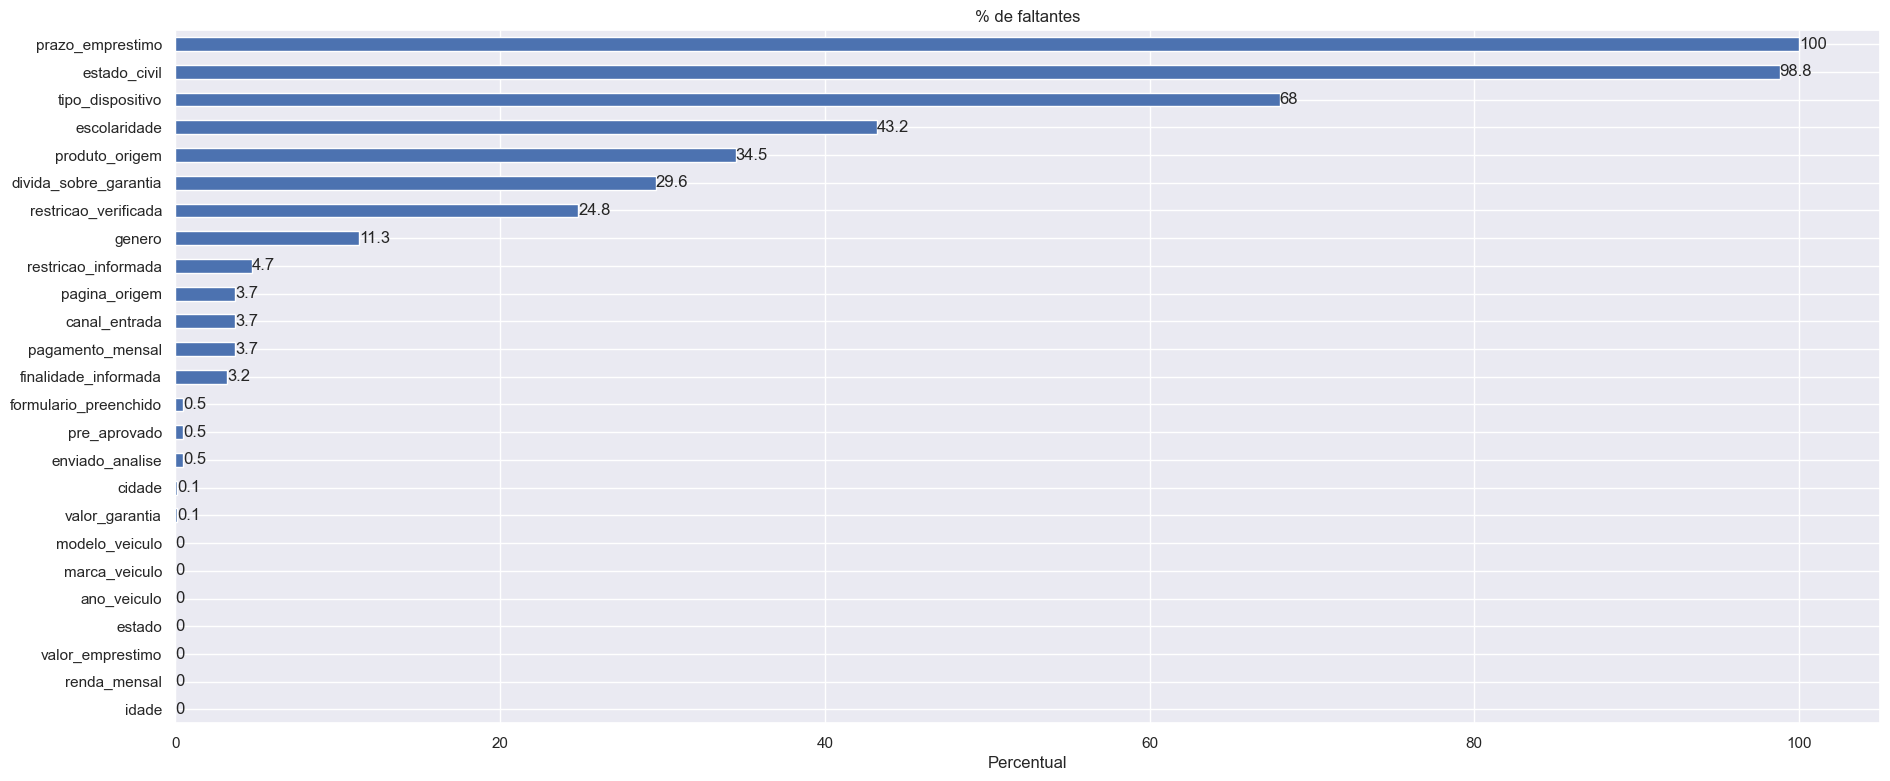

In [11]:
plota_ausentes(df, '% de faltantes', 'Percentual')

## 1.7. Estatística Descritiva


In [12]:
# Separando os atributos entre numéricos e categóricos
numericos = df.select_dtypes(include=['float', 'int'])

categoricos = df.select_dtypes(exclude=['float', 'int',])

### 1.7.1 Atributos Numéricos

In [13]:
numericos.describe().T

,count,mean,std,min,25%,50%,75%,max
id,35021.00,3000537.74,534366906.04,98326.00,133274.00,146443.00,160136.00,100001025857.00
idade,35019.00,38.33,11.58,18.00,30.00,36.00,46.00,116.00
renda_mensal,35019.00,11489.42,261470.77,0.00,2100.00,3200.00,5000.00,40004000.00
valor_garantia,35000.00,46797.27,891817.62,0.00,13000.00,20000.00,30000.00,99999999.00
valor_emprestimo,35018.00,13195.29,123821.03,1000.00,5000.00,9900.00,15000.00,18720000.00
divida_sobre_garantia,24650.00,8288.32,282407.78,0.00,0.00,0.00,7000.00,32000000.00
restricao_verificada,26329.00,0.37,0.48,0.00,0.00,0.00,1.00,1.00
cheques_sem_fundo,35021.00,0.03,0.18,0.00,0.00,0.00,0.00,1.00
dividas_vencidas,35021.00,0.01,0.08,0.00,0.00,0.00,0.00,1.00
dividas_bancarias,35021.00,0.16,0.37,0.00,0.00,0.00,0.00,1.00


### 1.7.2 Atributos Categóricos

In [14]:
categoricos.apply(lambda x: x.unique().shape[0])

cidade                   3987
estado                     28
estado_civil                7
finalidade_informada    17669
marca_veiculo              74
modelo_veiculo           2635
canal_entrada              11
cep                      5709
pagina_origem             270
produto_origem              8
genero                      3
tipo_dispositivo            4
escolaridade               10
dtype: int64

### 1.8 Variável Target

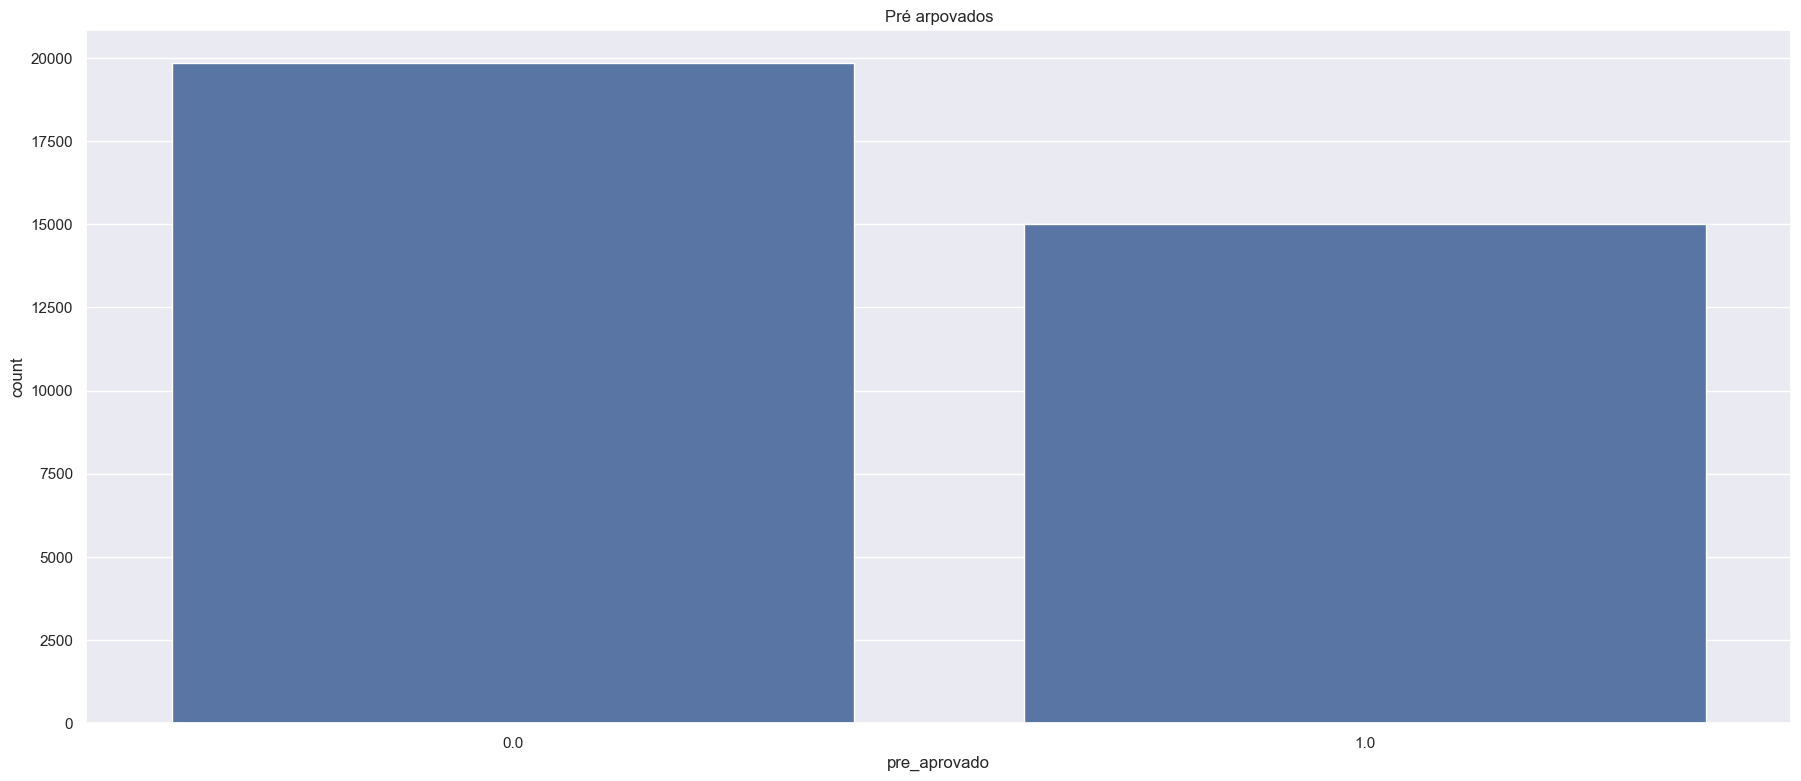

In [15]:
sns.countplot(data=df, x="pre_aprovado").set(title="Pré arpovados");

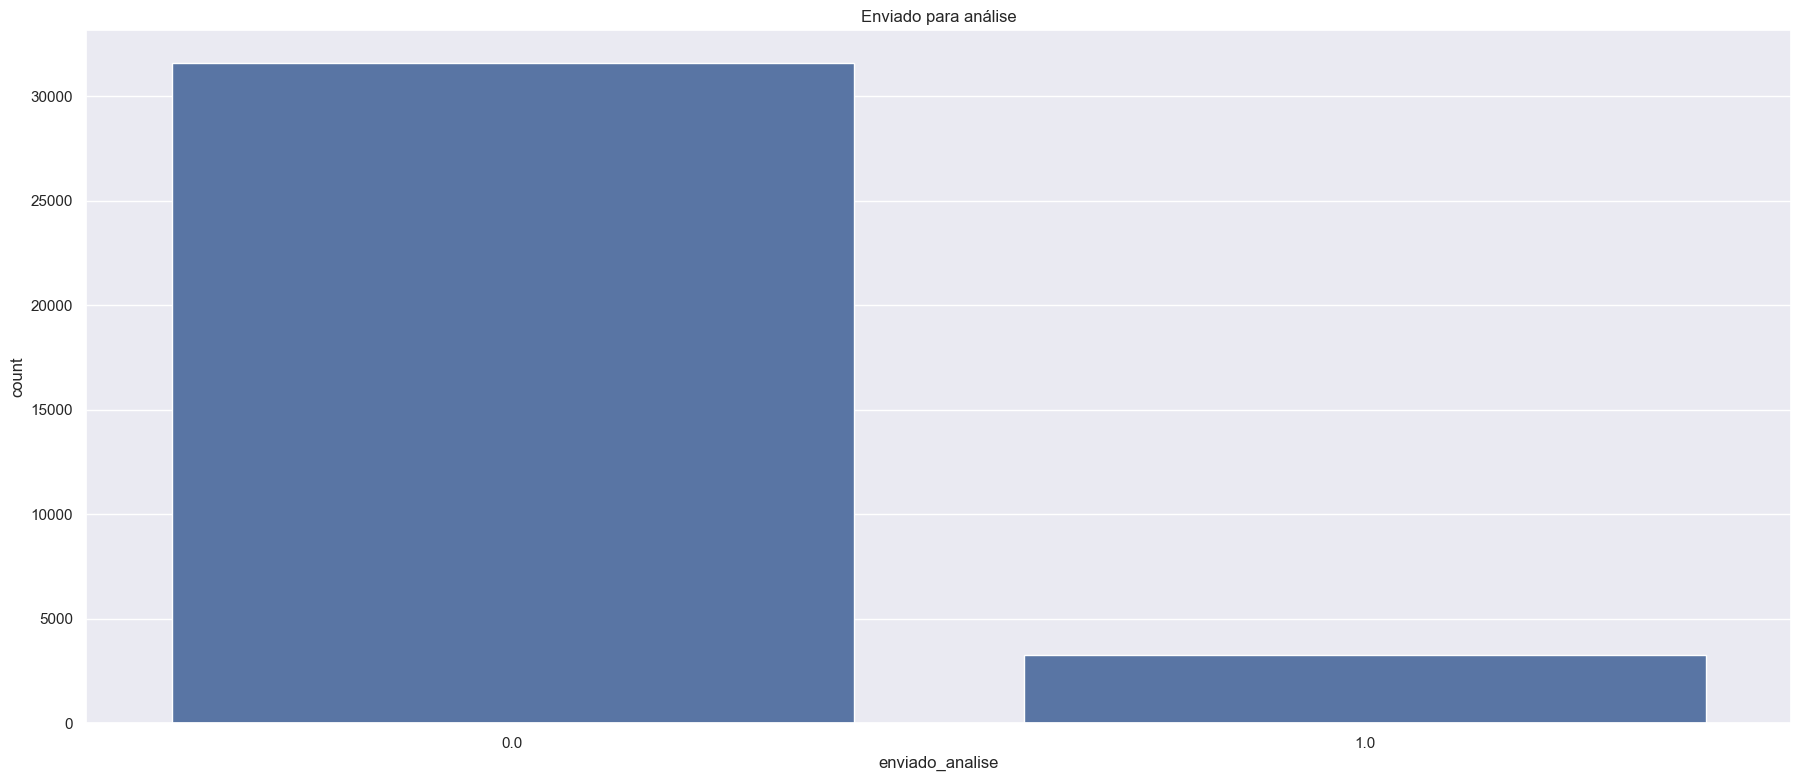

In [16]:
sns.countplot(data=df, x="enviado_analise").set(title="Enviado para análise");

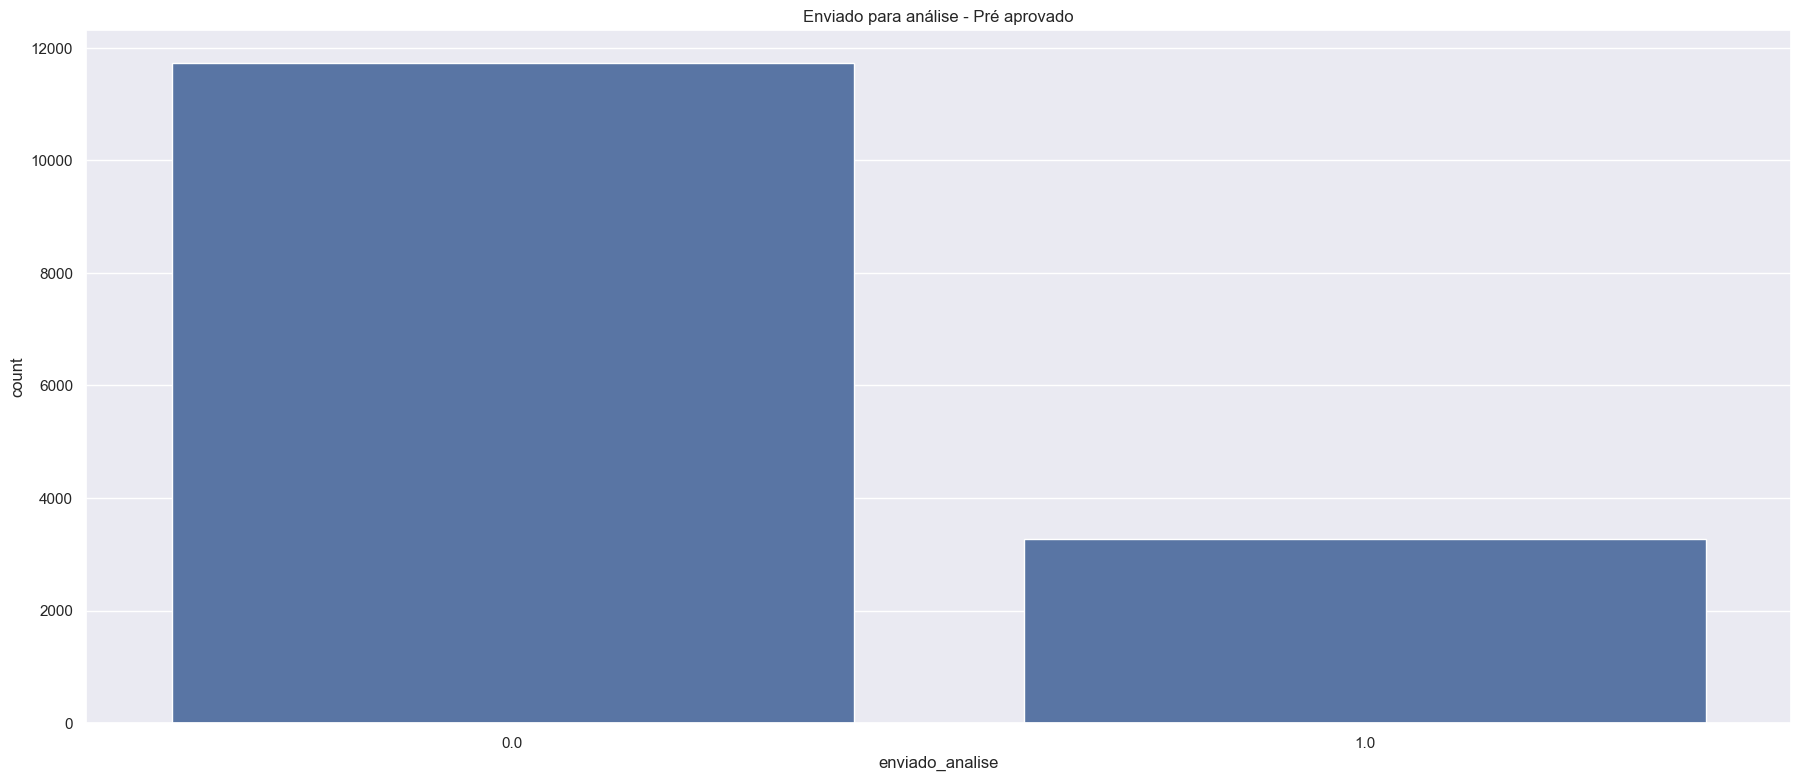

In [17]:
sns.countplot(data=df[df.pre_aprovado==1], x="enviado_analise").set(title="Enviado para análise - Pré aprovado");

# 2 - Análise exploratória dos dados

## 2.1. Análise Univariada

### Verificando a variância das variáveis numéricas

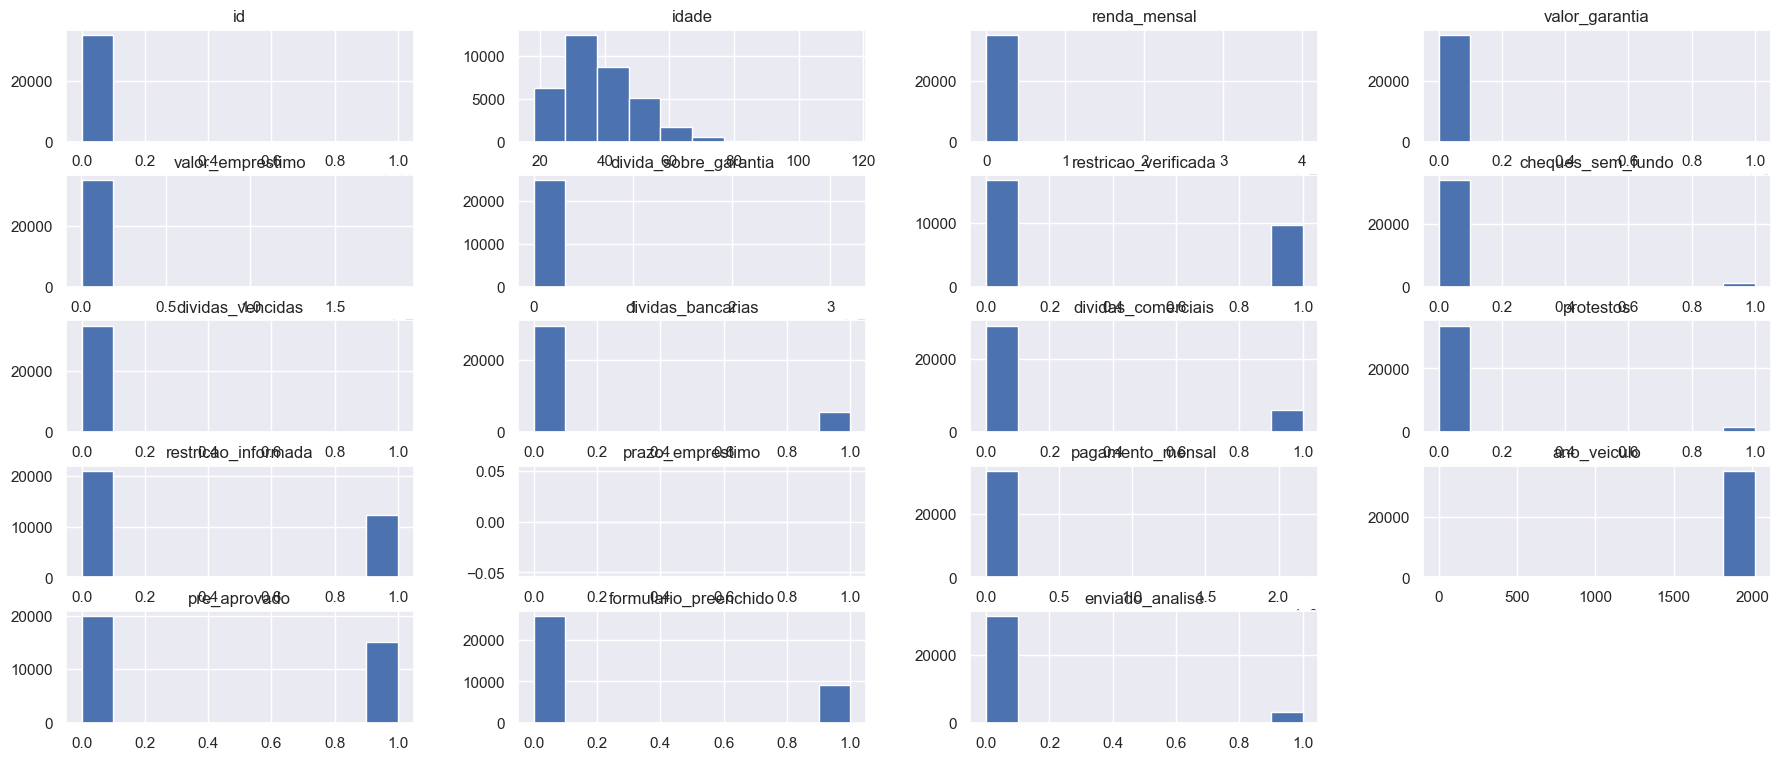

In [18]:
# Plotagem do histograma das variáveis numéricas
numericos.hist();

### Verificando os outliers das variáveis numéricas

In [19]:
numericos.columns

Index(['id', 'idade', 'renda_mensal', 'valor_garantia', 'valor_emprestimo',
       'divida_sobre_garantia', 'restricao_verificada', 'cheques_sem_fundo',
       'dividas_vencidas', 'dividas_bancarias', 'dividas_comerciais',
       'protestos', 'restricao_informada', 'prazo_emprestimo',
       'pagamento_mensal', 'ano_veiculo', 'pre_aprovado',
       'formulario_preenchido', 'enviado_analise'],
      dtype='object')

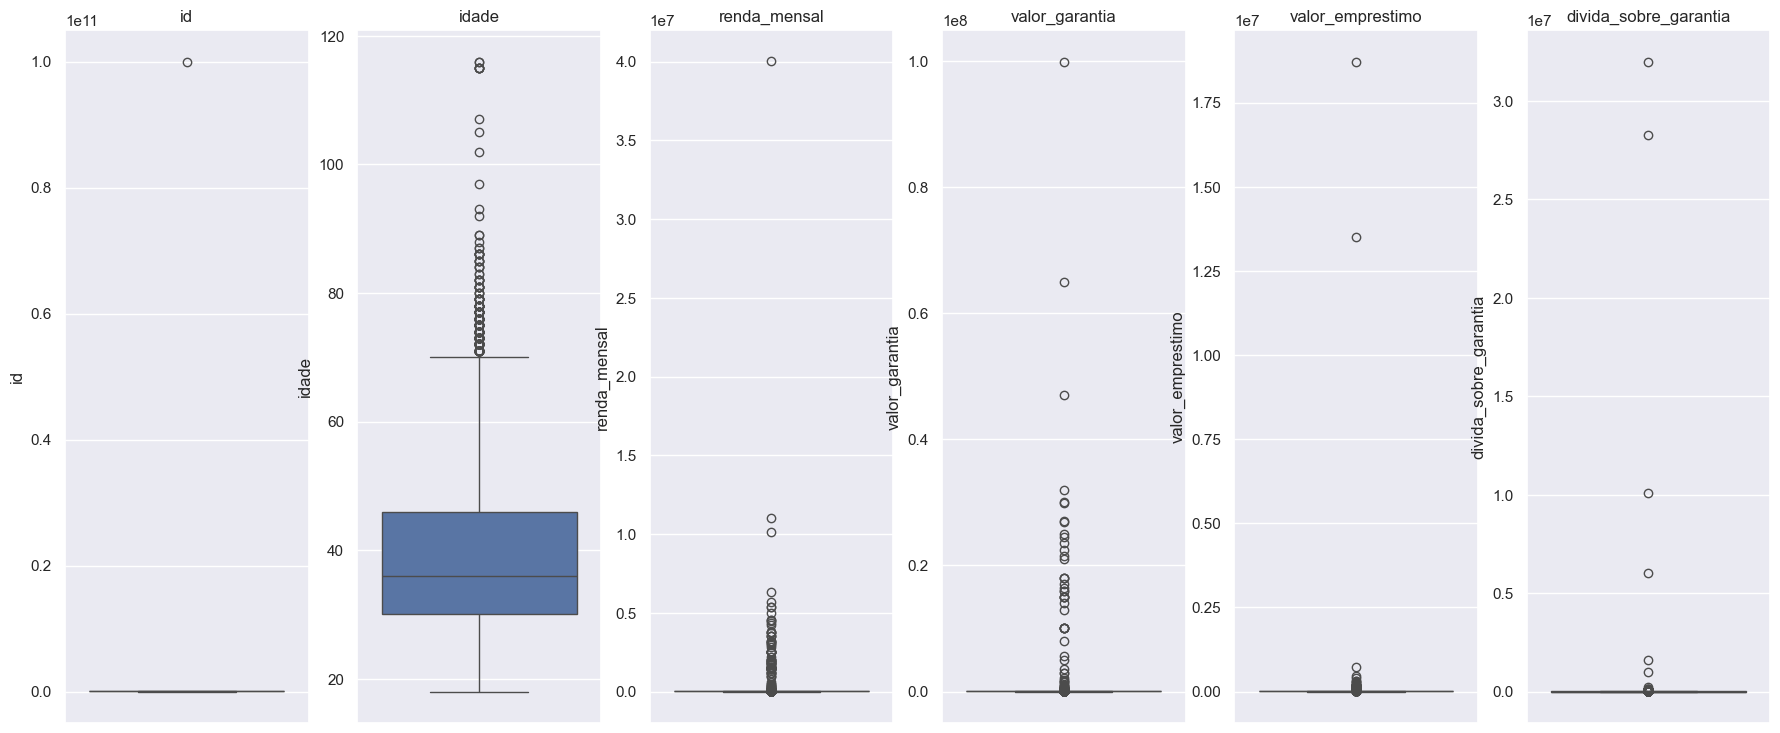

In [37]:
exibe_boxplot(numericos.iloc[:, :6], 6)

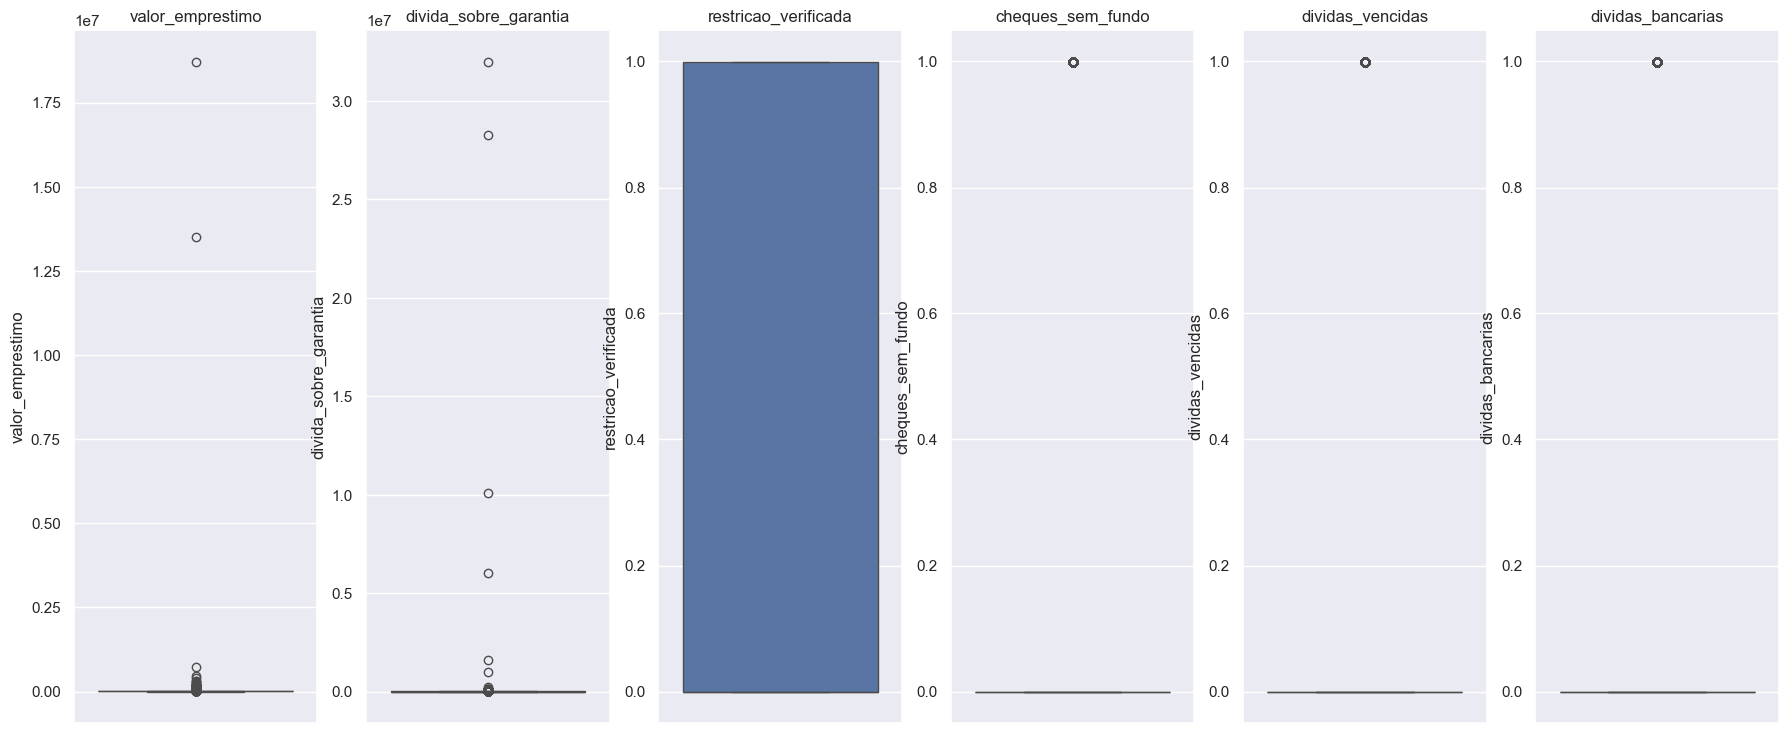

In [36]:
exibe_boxplot(numericos.iloc[:, 4:10], 6)

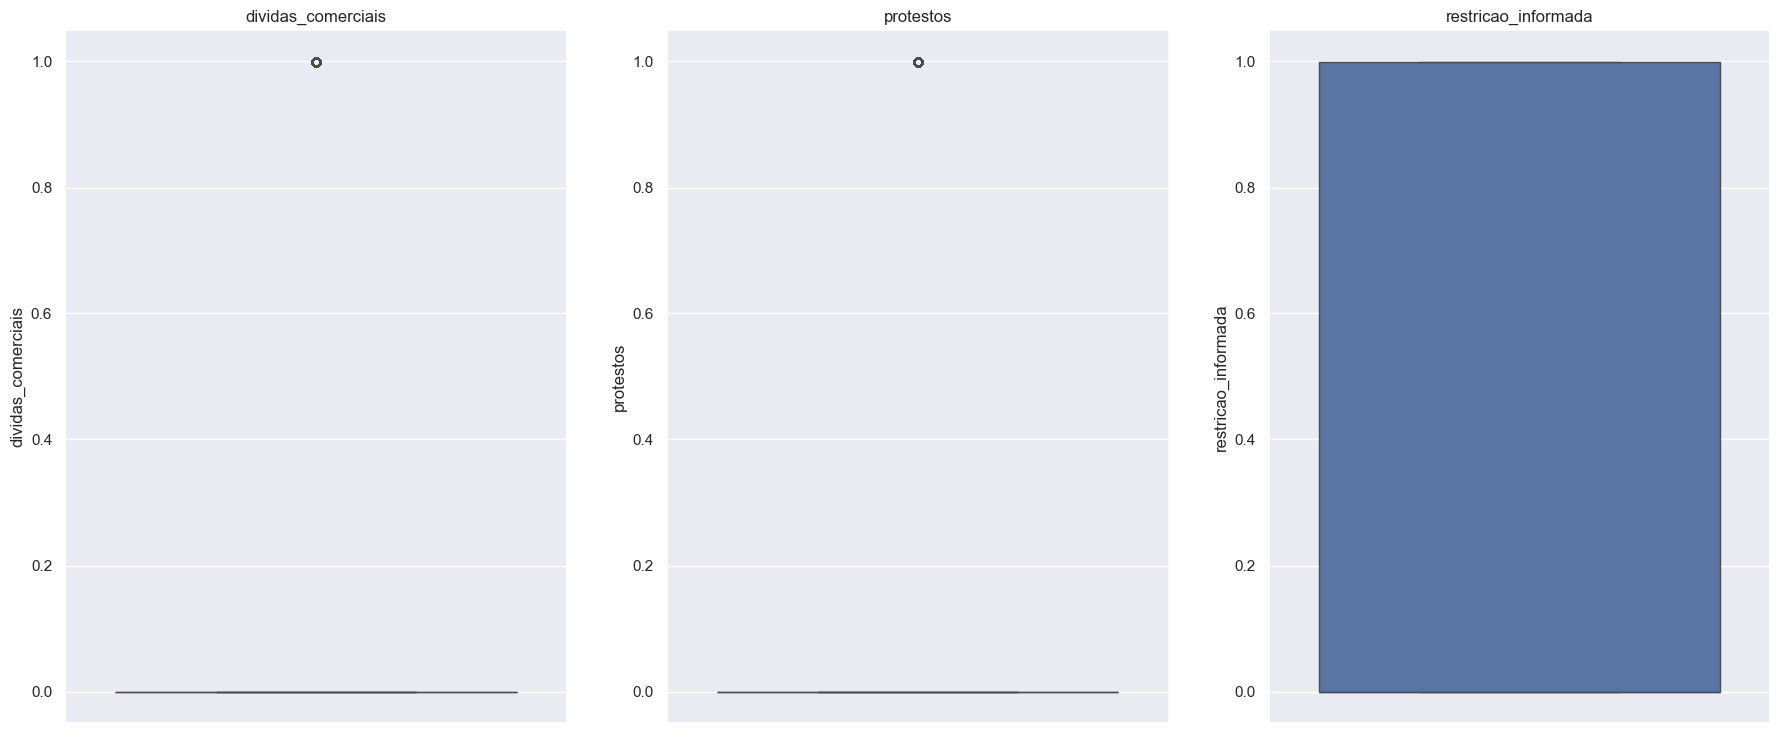

In [43]:
exibe_boxplot(numericos.iloc[:, 10:13], 3)

In [44]:
df.columns

Index(['id', 'idade', 'renda_mensal', 'valor_garantia', 'valor_emprestimo',
       'cidade', 'estado', 'divida_sobre_garantia', 'restricao_verificada',
       'cheques_sem_fundo', 'dividas_vencidas', 'dividas_bancarias',
       'dividas_comerciais', 'protestos', 'estado_civil',
       'restricao_informada', 'prazo_emprestimo', 'pagamento_mensal',
       'finalidade_informada', 'marca_veiculo', 'modelo_veiculo',
       'ano_veiculo', 'pre_aprovado', 'formulario_preenchido',
       'enviado_analise', 'canal_entrada', 'cep', 'pagina_origem',
       'produto_origem', 'genero', 'tipo_dispositivo', 'escolaridade'],
      dtype='object')

## 2.2. Análise Bivariada

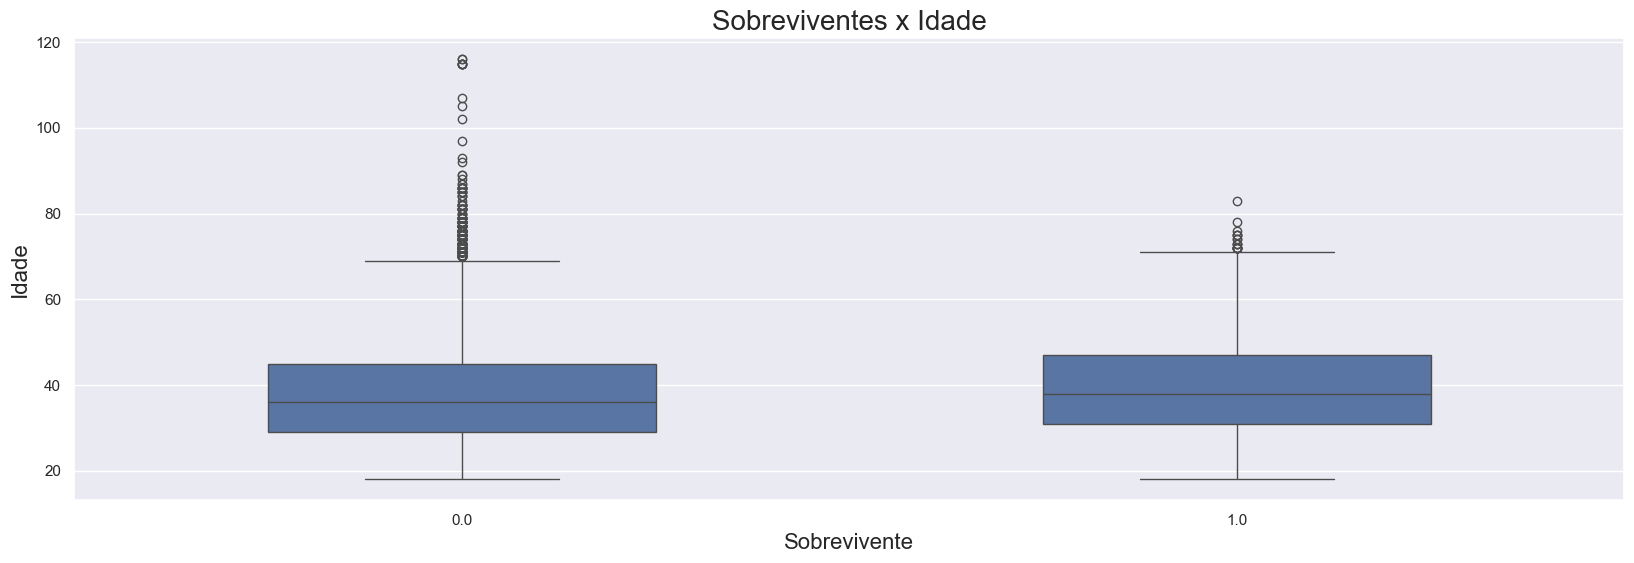

In [46]:
ax = sns.boxplot(y="idade", x="enviado_analise", data=df, orient="v", width=0.5)
ax.figure.set_size_inches(20, 6)
ax.set_title("Sobreviventes x Idade", fontsize=20)
ax.set_ylabel("Idade", fontsize=16)
ax.set_xlabel("Sobrevivente", fontsize=16);

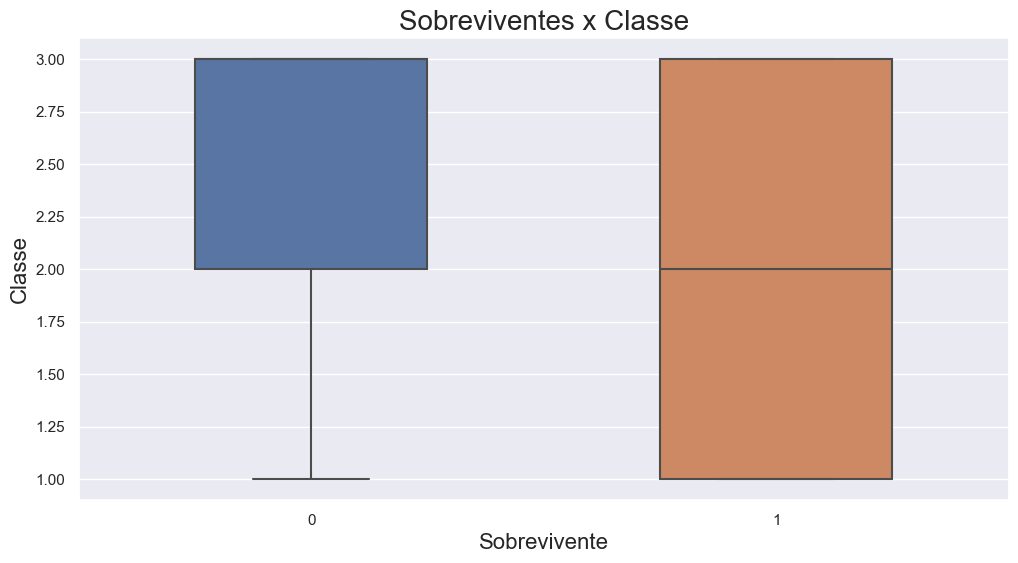

In [ ]:
ax = sns.boxplot(y="classe", x="sobreviveu", data=df, orient="v", width=0.5)
ax.figure.set_size_inches(12, 6)
ax.set_title("Sobreviventes x Classe", fontsize=20)
ax.set_ylabel("Classe", fontsize=16)
ax.set_xlabel("Sobrevivente", fontsize=16);

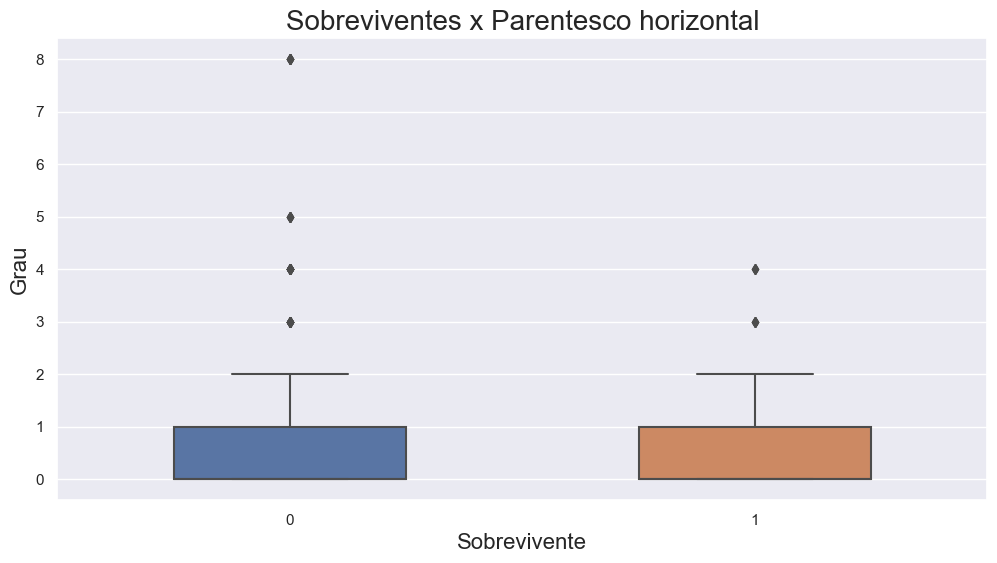

In [ ]:
ax = sns.boxplot(y="parentesco_horizontal", x="sobreviveu", data=df, orient="v", width=0.5)
ax.figure.set_size_inches(12, 6)
ax.set_title("Sobreviventes x Parentesco horizontal", fontsize=20)
ax.set_ylabel("Grau", fontsize=16)
ax.set_xlabel("Sobrevivente", fontsize=16);

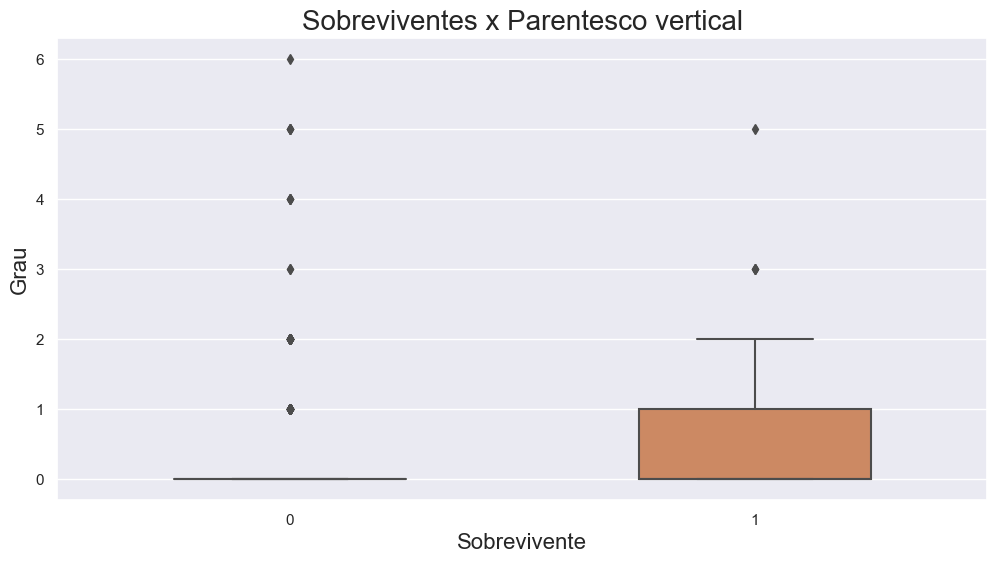

In [ ]:
ax = sns.boxplot(y="parentesco_vertical", x="sobreviveu", data=df, orient="v", width=0.5)
ax.figure.set_size_inches(12, 6)
ax.set_title("Sobreviventes x Parentesco vertical", fontsize=20)
ax.set_ylabel("Grau", fontsize=16)
ax.set_xlabel("Sobrevivente", fontsize=16);

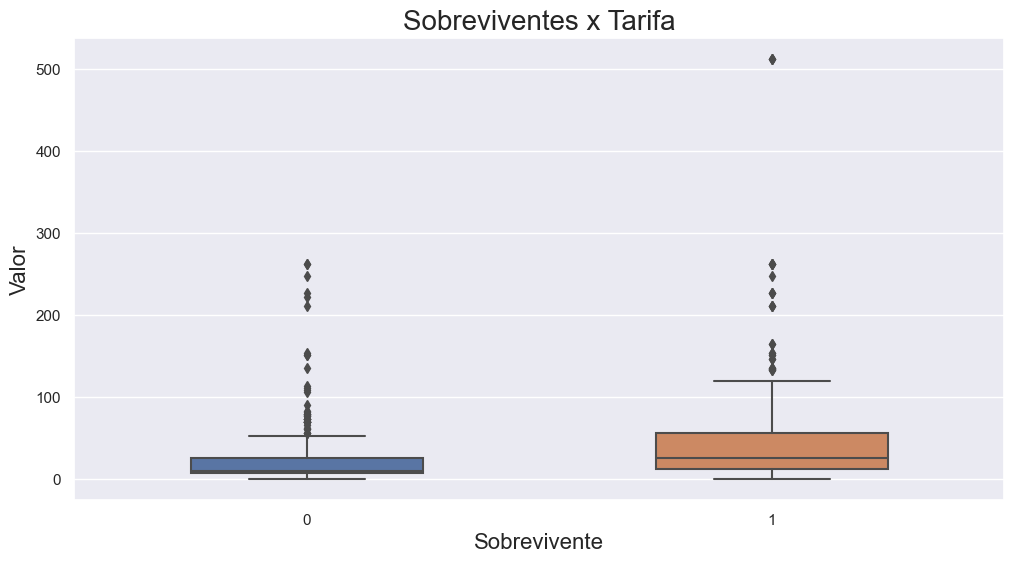

In [ ]:
ax = sns.boxplot(y="tarifa", x="sobreviveu", data=df, orient="v", width=0.5)
ax.figure.set_size_inches(12, 6)
ax.set_title("Sobreviventes x Tarifa", fontsize=20)
ax.set_ylabel("Valor", fontsize=16)
ax.set_xlabel("Sobrevivente", fontsize=16);

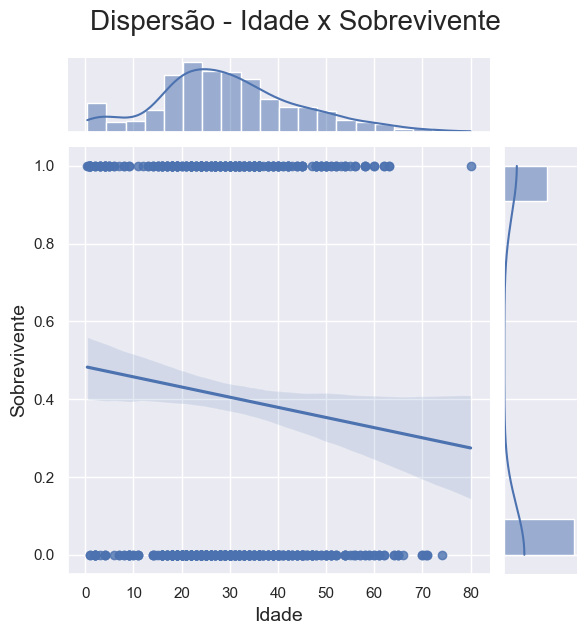

In [ ]:
ax = sns.jointplot(x="idade", y="sobreviveu", data=df, kind="reg")
ax.fig.suptitle("Dispersão - Idade x Sobrevivente", fontsize=20, y=1.05)
ax.set_axis_labels("Idade", "Sobrevivente", fontsize=14)
ax;

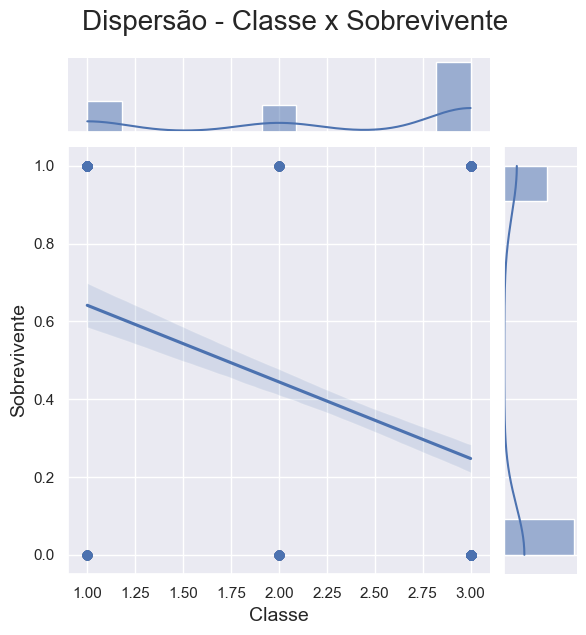

In [ ]:
ax = sns.jointplot(x="classe", y="sobreviveu", data=df, kind="reg")
ax.fig.suptitle("Dispersão - Classe x Sobrevivente", fontsize=20, y=1.05)
ax.set_axis_labels("Classe", "Sobrevivente", fontsize=14)
ax;

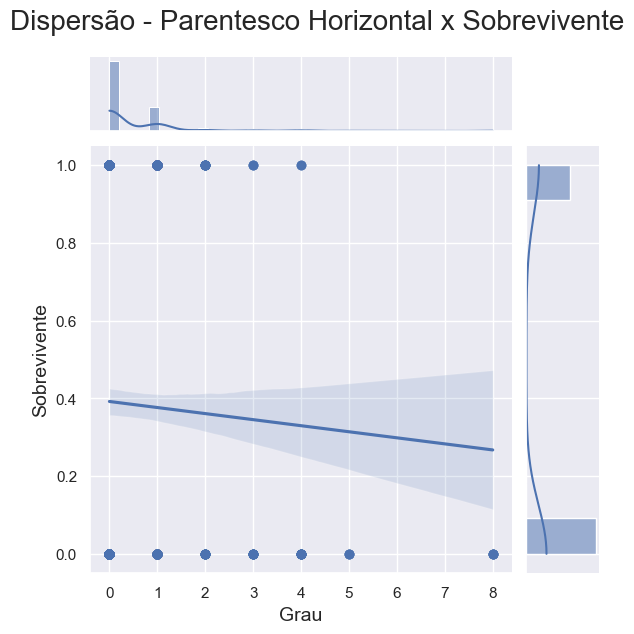

In [ ]:
ax = sns.jointplot(x="parentesco_horizontal", y="sobreviveu", data=df, kind="reg")
ax.fig.suptitle("Dispersão - Parentesco Horizontal x Sobrevivente", fontsize=20, y=1.05)
ax.set_axis_labels("Grau", "Sobrevivente", fontsize=14)
ax;

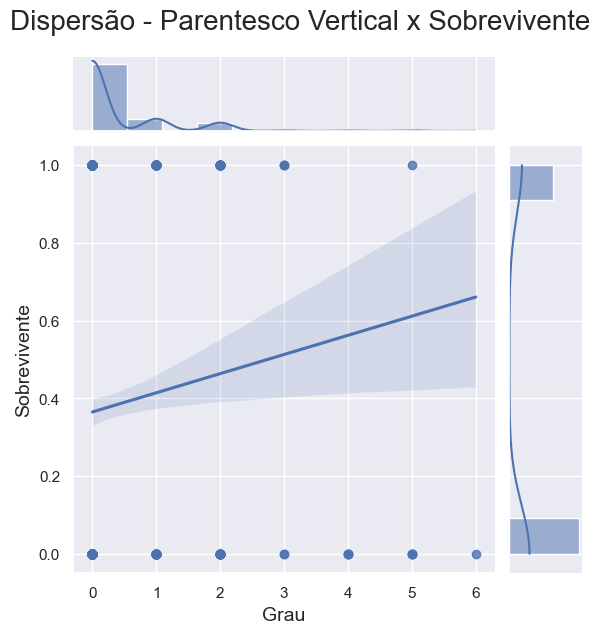

In [ ]:
ax = sns.jointplot(x="parentesco_vertical", y="sobreviveu", data=df, kind="reg")
ax.fig.suptitle("Dispersão - Parentesco Vertical x Sobrevivente", fontsize=20, y=1.05)
ax.set_axis_labels("Grau", "Sobrevivente", fontsize=14)
ax;

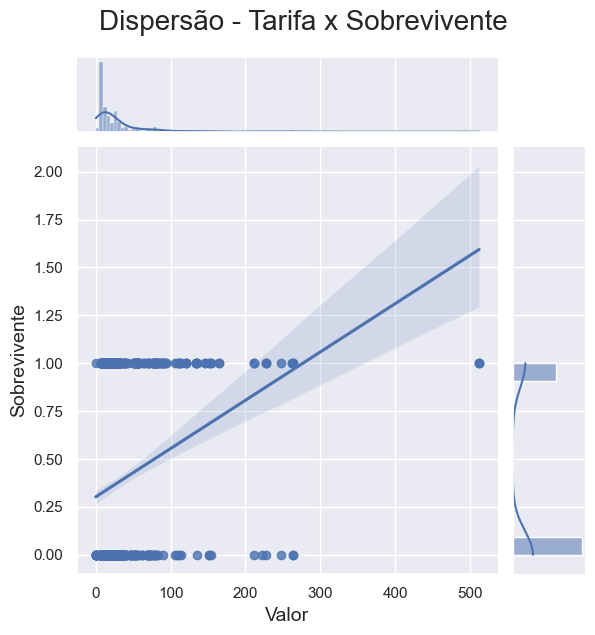

In [ ]:
ax = sns.jointplot(x="tarifa", y="sobreviveu", data=df, kind="reg")
ax.fig.suptitle("Dispersão - Tarifa x Sobrevivente", fontsize=20, y=1.05)
ax.set_axis_labels("Valor", "Sobrevivente", fontsize=14)
ax;

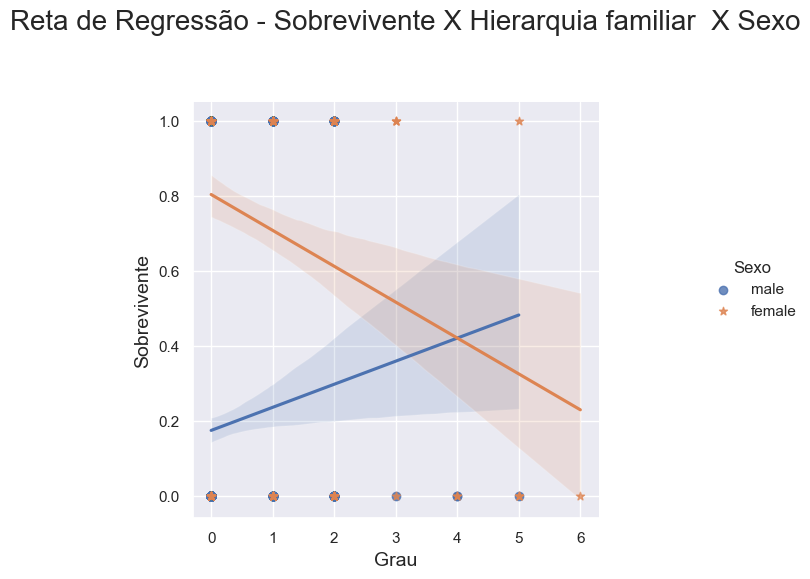

In [ ]:
ax = sns.lmplot(x="parentesco_vertical", y="sobreviveu", data=df, hue="sexo", markers=["o", "*"], legend=False)
ax.fig.suptitle("Reta de Regressão - Sobrevivente X Hierarquia familiar  X Sexo", fontsize=20, y=1.15)
ax.set_xlabels("Grau", fontsize=14)
ax.set_ylabels("Sobrevivente", fontsize=14)
ax.add_legend(title="Sexo")
ax;

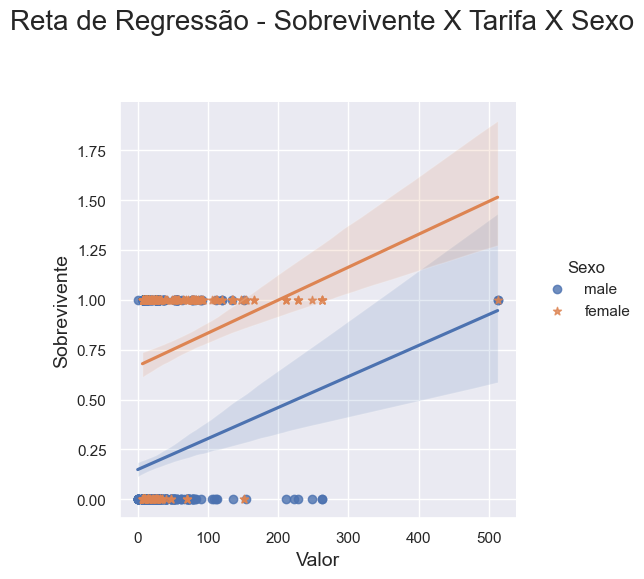

In [ ]:
ax = sns.lmplot(x="tarifa", y="sobreviveu", data=df, hue="sexo", markers=["o", "*"], legend=False)
ax.fig.suptitle("Reta de Regressão - Sobrevivente X Tarifa X Sexo", fontsize=20, y=1.15)
ax.set_xlabels("Valor", fontsize=14)
ax.set_ylabels("Sobrevivente", fontsize=14)
ax.add_legend(title="Sexo")
ax;

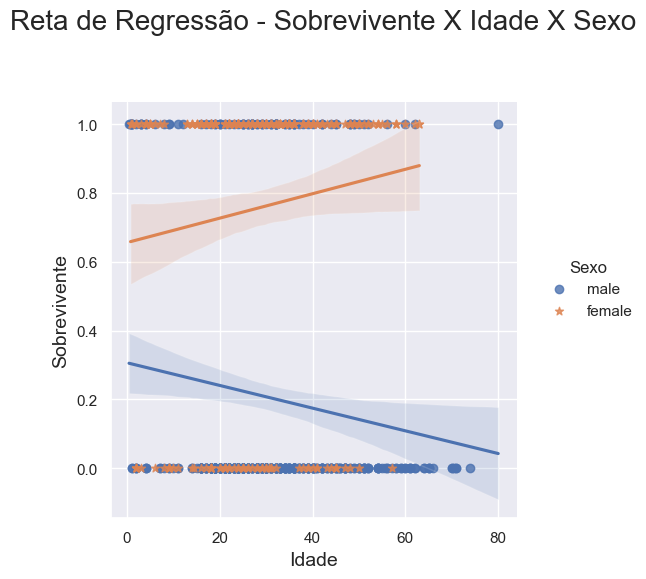

In [ ]:
ax = sns.lmplot(x="idade", y="sobreviveu", data=df, hue="sexo", markers=["o", "*"], legend=False)
ax.fig.suptitle("Reta de Regressão - Sobrevivente X Idade X Sexo", fontsize=20, y=1.15)
ax.set_xlabels("Idade", fontsize=14)
ax.set_ylabels("Sobrevivente", fontsize=14)
ax.add_legend(title="Sexo")
ax;

## 2.3. Análise Multivariada

### Verificando a correlação entre as variáveis

In [47]:
corr = numericos.corr().round(1)
corr

,id,idade,renda_mensal,valor_garantia,valor_emprestimo,divida_sobre_garantia,restricao_verificada,cheques_sem_fundo,dividas_vencidas,dividas_bancarias,dividas_comerciais,protestos,restricao_informada,prazo_emprestimo,pagamento_mensal,ano_veiculo,pre_aprovado,formulario_preenchido,enviado_analise
id,1.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,NaN,0.00,0.00,-0.00,0.00,-0.00
idade,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.10,-0.00,NaN,-0.00,0.00,0.00,0.00,0.00
renda_mensal,-0.00,0.00,1.00,0.10,0.10,0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,NaN,0.00,0.00,-0.00,0.00,-0.00
valor_garantia,-0.00,0.00,0.10,1.00,0.20,0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,0.00,NaN,0.10,0.00,0.00,-0.00,-0.00
valor_emprestimo,-0.00,0.00,0.10,0.20,1.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,0.40,0.00,0.00,0.00,0.00
divida_sobre_garantia,0.00,0.00,0.00,0.00,-0.00,1.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,NaN,-0.00,0.00,-0.00,-0.00,-0.00
restricao_verificada,-0.00,0.00,-0.00,-0.00,0.00,-0.00,1.00,0.30,0.10,0.70,0.70,0.30,0.60,NaN,-0.00,-0.10,-0.50,-0.00,-0.30
cheques_sem_fundo,-0.00,0.00,-0.00,0.00,0.00,-0.00,0.30,1.00,0.10,0.20,0.20,0.20,0.20,NaN,-0.00,0.00,-0.10,0.00,-0.10
dividas_vencidas,-0.00,-0.00,0.00,-0.00,0.00,-0.00,0.10,0.10,1.00,0.10,0.10,0.00,0.10,NaN,-0.00,0.00,-0.00,0.00,-0.00
dividas_bancarias,-0.00,0.00,-0.00,0.00,0.00,-0.00,0.70,0.20,0.10,1.00,0.50,0.20,0.40,NaN,0.00,0.10,-0.20,-0.00,-0.10


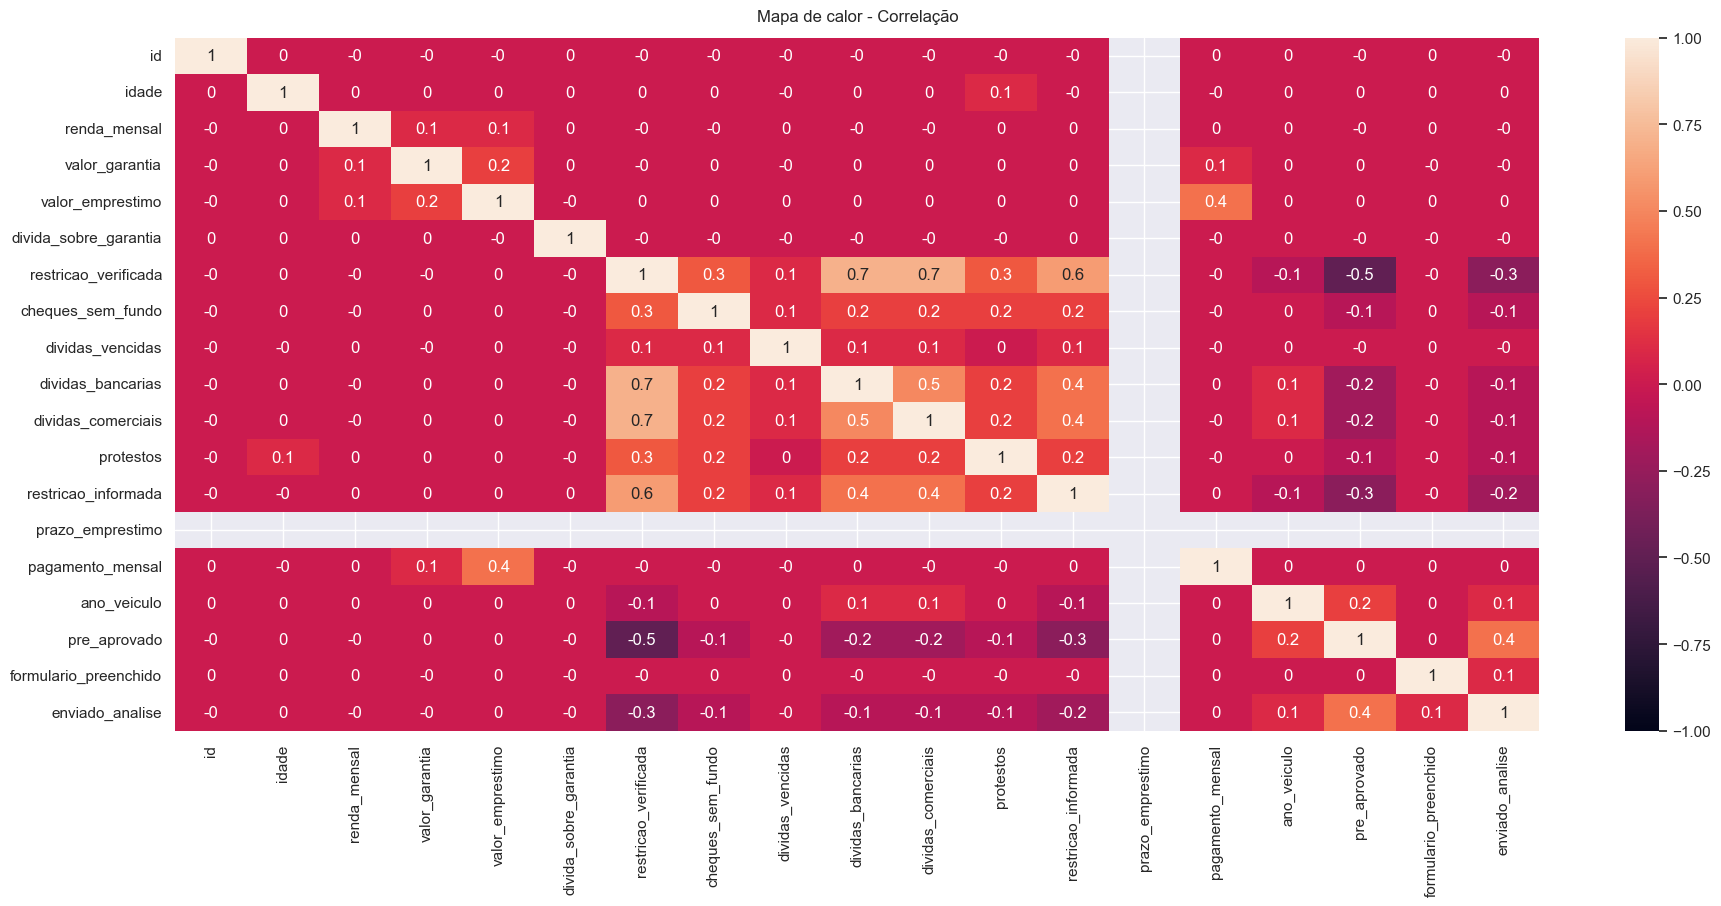

In [48]:
# Plotando mapa de calor das correlações
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True)
heatmap.set_title("Mapa de calor - Correlação", fontdict={"fontsize": 12}, pad=12);

# 3 - Engenharia de Features

In [126]:
df2 = df.copy()

In [125]:
df2['tipo_dispositivo'].mode()[0]

'c'

## 3.1. Criando features novas

In [127]:
df2.drop(columns=['id', 'prazo_emprestimo', 'estado_civil', ], inplace=True)
# Inputando média para os valores ausentes
for col in df2.columns:
    if df2[col].dtypes == 'O':
        df2[col].fillna(df2[col].dropna().mode()[0], inplace=True)
    else:
        df2[col].fillna(df2[col].median(), inplace=True)

df2.isna().mean().sort_values()

idade                   0.00
genero                  0.00
produto_origem          0.00
pagina_origem           0.00
cep                     0.00
canal_entrada           0.00
enviado_analise         0.00
formulario_preenchido   0.00
pre_aprovado            0.00
ano_veiculo             0.00
modelo_veiculo          0.00
marca_veiculo           0.00
finalidade_informada    0.00
tipo_dispositivo        0.00
pagamento_mensal        0.00
protestos               0.00
dividas_comerciais      0.00
dividas_bancarias       0.00
dividas_vencidas        0.00
cheques_sem_fundo       0.00
restricao_verificada    0.00
divida_sobre_garantia   0.00
estado                  0.00
cidade                  0.00
valor_emprestimo        0.00
valor_garantia          0.00
renda_mensal            0.00
restricao_informada     0.00
escolaridade            0.00
dtype: float64

## 3.2. Filtrando features

In [136]:
# Mantendo somente as colunas que serão usadas
df_final = df2[df2.pre_aprovado == 1].copy()
df_final.drop(columns=['pre_aprovado'], inplace=True)
df_final.head(2)

,idade,renda_mensal,valor_garantia,valor_emprestimo,cidade,estado,divida_sobre_garantia,restricao_verificada,cheques_sem_fundo,dividas_vencidas,dividas_bancarias,dividas_comerciais,protestos,restricao_informada,pagamento_mensal,finalidade_informada,marca_veiculo,modelo_veiculo,ano_veiculo,formulario_preenchido,enviado_analise,canal_entrada,cep,pagina_origem,produto_origem,genero,tipo_dispositivo,escolaridade
7,52.00,5668.00,24000.00,5000.00,São Paulo,SP,900.00,0.00,0,0,0,0,0,0.00,161.77,cobrir cheque especial,Nissan,LIVINA 1.6 16V Flex Fuel 5p,2011.00,0.00,0.00,search,4028XXXX,/emprestimos/solicitar,PersonalLoan,female,c,"Ensino médio completo (antigo 2º grau, secundá..."
11,20.00,5000.00,14200.00,5000.00,Guarulhos,SP,1500.00,0.00,0,0,0,0,0,0.00,279.56,Pagar dívidas,VW - VolksWagen,Fox City 1.0Mi/ 1.0Mi Total Flex 8V 3p,2004.00,0.00,0.00,direct,7060XXXX,/emprestimos,PersonalLoan,male,c,"Ensino médio completo (antigo 2º grau, secundá..."


In [137]:
df_final.shape

(14999, 28)

## 4.1. Dataset split


# 4 - Preparação dos dados

In [138]:
# Variáveis preditoras (x)
X = df_final.drop(columns=['enviado_analise'])

# Variável target (y)
y = df_final['enviado_analise']

# Divisão em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## 4.2. Tratamento de faltantes

In [ ]:
# Preenchendo faltantes nos dados de treino
# X_train.idade.fillna(X_train.idade.median(), inplace=True)

# Preenchendo faltantes nos dados de teste
# X_test.idade.fillna(X_test.idade.median(), inplace=True)

## 4.3. Transformação dos dados

In [153]:
# # Transformando variáveis categóricas (dados de treino)
enc = LabelEncoder()
tg = TargetEncoder()

X_train[['cidade', 'estado',  'finalidade_informada',
       'marca_veiculo', 'modelo_veiculo', 'canal_entrada', 'cep',
       'pagina_origem', 'produto_origem', 'genero', 'tipo_dispositivo',
       'escolaridade']] = tg.fit_transform(X_train[['cidade', 'estado', 'finalidade_informada',
       'marca_veiculo', 'modelo_veiculo', 'canal_entrada', 'cep',
       'pagina_origem', 'produto_origem', 'genero', 'tipo_dispositivo',
       'escolaridade']], y_train)

# # Transformando variáveis categóricas (dados de teste)
X_test[['cidade', 'estado', 'finalidade_informada',
       'marca_veiculo', 'modelo_veiculo', 'canal_entrada', 'cep',
       'pagina_origem', 'produto_origem', 'genero', 'tipo_dispositivo',
       'escolaridade']] = tg.fit_transform(X_test[['cidade', 'estado',  'finalidade_informada',
       'marca_veiculo', 'modelo_veiculo', 'canal_entrada', 'cep',
       'pagina_origem', 'produto_origem', 'genero', 'tipo_dispositivo',
       'escolaridade']], y_test)


## 4.4. Normalização dos dados

In [154]:
# Normalização dos dados de treino
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)

# Aplicar a mesma normalização aos dados de teste
X_test_normalized = scaler.transform(X_test)

## 4.5. Feature Importance

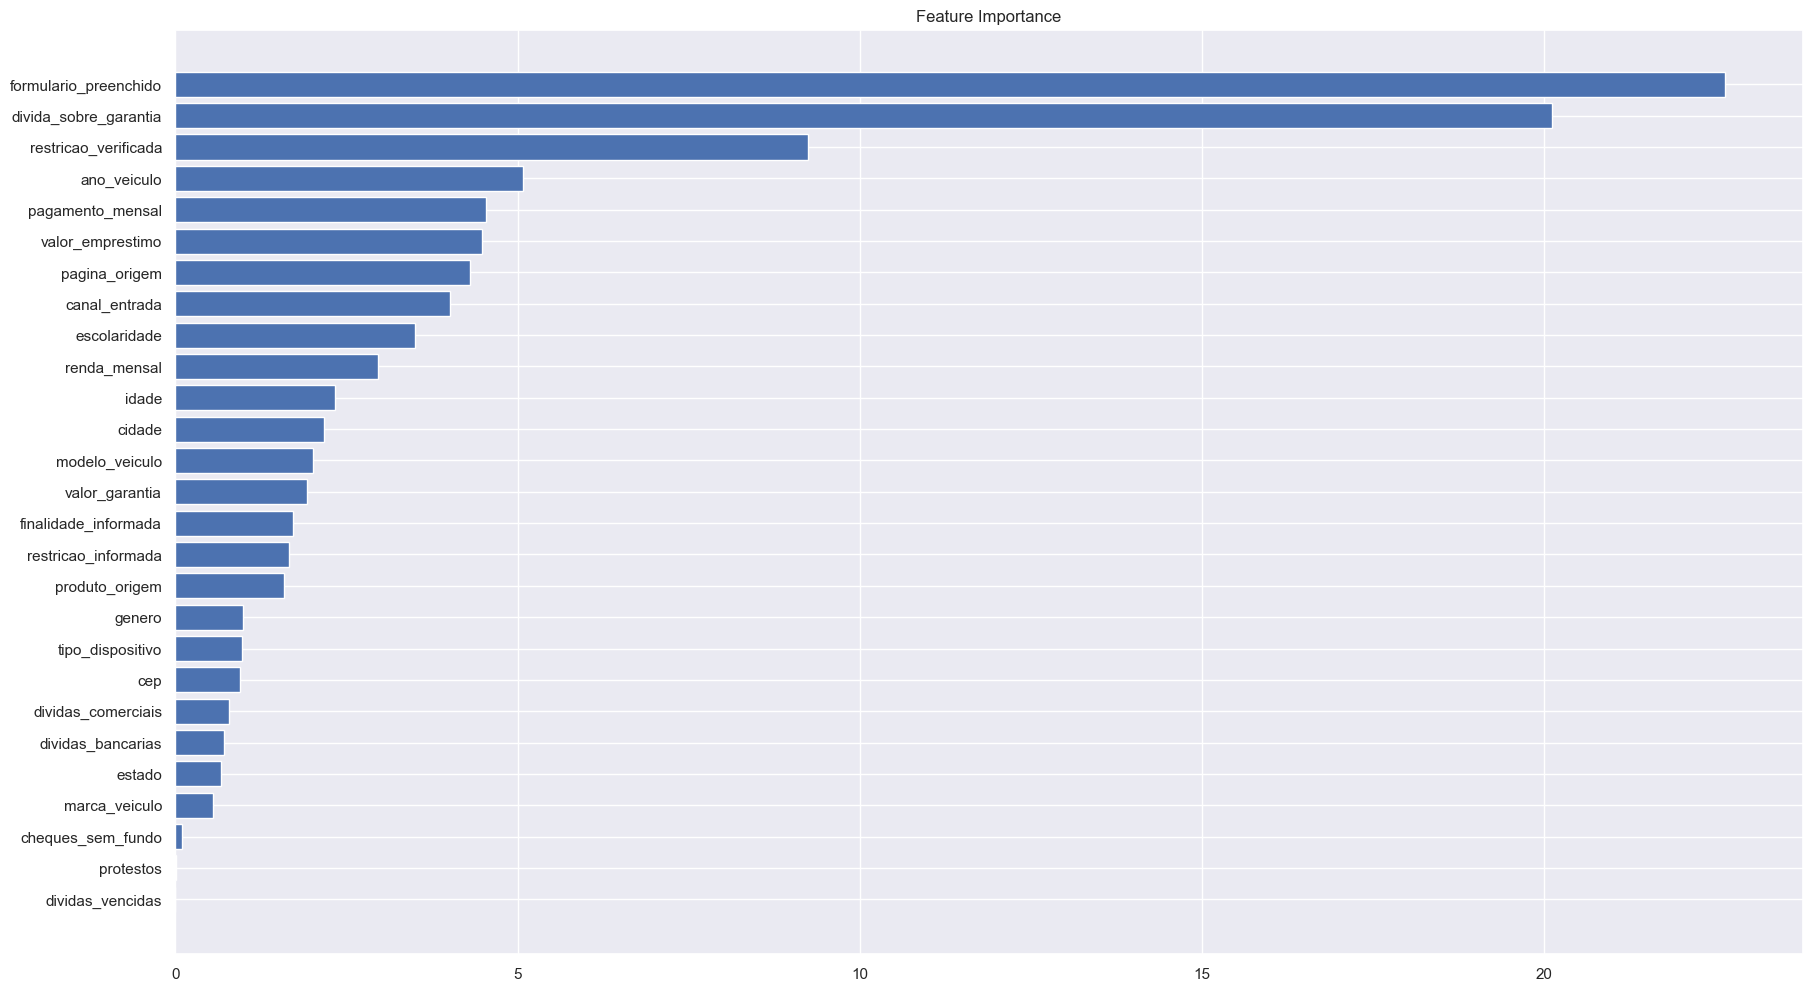

In [173]:
# Identifica as características categóricas no DataFrame de treinamento (todas as não numéricas)
categorical_features = list(X_train.select_dtypes(exclude=['int', 'float']).columns)

# Cria objetos de Pool para treinamento e teste, incluindo as características categóricas
train_pool = Pool(X_train, y_train, categorical_features)
test_pool = Pool(X_test, y_test, categorical_features)

# Configura o modelo CatBoostRegressor
model = CatBoostRegressor(iterations=500, max_depth=5, learning_rate=0.05, random_seed=42, logging_level='Silent')

# Treina o modelo CatBoostRegressor com os dados de treinamento
model.fit(X_train, y_train, eval_set=test_pool, cat_features=categorical_features, use_best_model=True, early_stopping_rounds=10)

# Calcula a importância das características usando o modelo treinado
feature_importance = model.feature_importances_

# Ordena os índices das características com base em sua importância
sorted_idx = np.argsort(feature_importance)

# Cria um gráfico de barras horizontais para visualizar a importância das características
fig = plt.figure(figsize=(21, 12))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance');

# 5 - Modeling

## 5.1. Regressão Logística

In [163]:
# Criando o modelo de Regressão Linear Lasso
regressao = LogisticRegression(random_state=42)

# Treinando o modelo
regressao.fit(X_train_normalized, y_train)

# Fazendo previsões nos dados de teste com o modelo treinado
y_pred = regressao.predict(X_test_normalized)

metricas_log = calcula_metricas("Regressão Logística", y_test, y_pred)
metricas_log

,Modelo,Precision,F1,Accuracy
0,Regressão Logística,0.48,0.24,0.78


## 5.2. Random Forest

In [168]:
# Criando o modelo de Regressão Linear Lasso
forest = RandomForestClassifier(max_depth=50, random_state=42)

# Treinando o modelo
forest.fit(X_train_normalized, y_train)

# Fazendo previsões nos dados de teste com o modelo treinado
y_pred = forest.predict(X_test_normalized)

metricas_rf = calcula_metricas("Random Forest", y_test, y_pred)
metricas_rf

,Modelo,Precision,F1,Accuracy
0,Random Forest,0.55,0.28,0.79


## 5.3. Decision Tree

In [165]:
# Criando o modelo de Regressão Linear Lasso
d_tree = DecisionTreeClassifier(random_state=42)

# Treinando o modelo
d_tree.fit(X_train_normalized, y_train)

# Fazendo previsões nos dados de teste com o modelo treinado
y_pred = d_tree.predict(X_test_normalized)

metricas_dt = calcula_metricas("Decision Tree", y_test, y_pred)
metricas_dt

,Modelo,Precision,F1,Accuracy
0,Decision Tree,0.34,0.36,0.70


# 6 - Escolhendo melhor modelo

In [169]:
metricas = pd.concat([metricas_dt, metricas_log, metricas_rf])
metricas

,Modelo,Precision,F1,Accuracy
0,Decision Tree,0.34,0.36,0.70
0,Regressão Logística,0.48,0.24,0.78
0,Random Forest,0.55,0.28,0.79


# 7 - Tunagem de hiperparâmetros

In [174]:
# Configurando o nível de log do Optuna para suprimir saída detalhada
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Definindo a função objetivo para otimização
def objective(trial):

    # Parâmetros e faixa de valores a serem testados
    max_depth = trial.suggest_int("rf_max_depth", 2, 64)
    min_samples_split = trial.suggest_int("rf_min_samples_split", 2, 10)
    n_estimators = trial.suggest_int("n_estimators", 2, 50)
   
    # Cria um modelo com os hiperparâmetros sugeridos
    rf_model = RandomForestClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        n_estimators=n_estimators,
        random_state=42)
    
    # Calcula a pontuação média usando validação cruzada
    score = cross_val_score(rf_model, X_train, y_train, cv=3, scoring='r2').mean()   
    return score

# Cria uma instância de estudo do Optuna para maximização
study = optuna.create_study(direction="maximize")

# Realiza a otimização da função objetivo com 100 iterações de teste
study.optimize(objective, n_trials=100)

# Obtém a melhor tentativa após a otimização
trial = study.best_trial

# Imprime a melhor pontuação encontrada
print("Best Score: ", trial.value)

# Imprime os hiperparâmetros correspondentes à melhor pontuação
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))


Best Score:  -0.1390545463274914
Best Params: 
  rf_max_depth: 21
  rf_min_samples_split: 9
  n_estimators: 36
